In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import regularizers
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
import math
seed=42
import tensorflow as tf

!pip install pyDOE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.11.0
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=cf1e1e4e54bd60fbd7c19350b3db50c734ef1dda087de00bc679ea9ba9c5abd0
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [2]:
#you need to add a dataset with GaussJacobiQuadRule_V3 on the right 
import sys
sys.path.insert(1, '/kaggle/input/quadrule')
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights

import pyDOE

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pyDOE import lhs
#from GaussJacobiQuadRule_V3.py import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights
import time

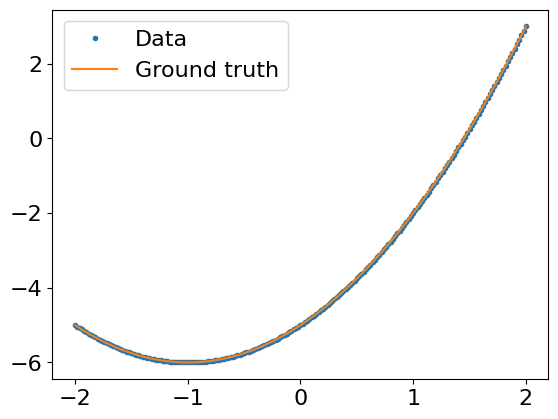

In [3]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + 0*tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x),  label='Ground truth')
plt.legend();

In [4]:

class Model(tf.keras.Model):
  def __init__(self,*kwargs):
    super().__init__()
    #structure of the nework maybe implment a general way
    self.dense1 = tf.keras.layers.Dense(units=16,
                                        activation='gelu',
                                        kernel_initializer=tf.random.normal,
                                        bias_initializer=tf.random.normal)
    self.dense2 = tf.keras.layers.Dense(units=16,
                                    activation='gelu',
                                    kernel_initializer=tf.random.normal,
                                    bias_initializer=tf.random.normal)
    self.y = tf.keras.layers.Dense(1)
    self.history=[]
    
  def call(self, x, training=True):
    x = x[:, tf.newaxis]
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.y(x)
    return tf.squeeze(x, axis=1)

  def net_du(self, x):
    t = tf.constant(x)
    with tf.GradientTape() as g:
      g.watch(x)
      with tf.GradientTape() as gg:
        gg.watch(x)
        y = model(x)
      dy_dx = gg.gradient(y, x)  # dy_dx = 2 * x
    d2y_dx2 = g.gradient(dy_dx, x)  # d2y_dx2 = 2
    return dy_dx,d2y_dx2

  def train(self,x,y):
    variables = self.variables
    optimizer = tf.optimizers.Adam(learning_rate=0.001)
    print('-->training_starting')
    for step in range(2000):
      with tf.GradientTape() as tape:
        prediction = model(x)
        error = (y-prediction)**2
        error_der=(self.net_du(x)-2*x)**2
        mean_error = tf.reduce_mean(error)
        mean_error_der=tf.reduce_mean(error_der)
        
      gradient = tape.gradient(mean_error+mean_error_der, variables)
      optimizer.apply_gradients(zip(gradient, variables))

      if step % 100 == 0:
        print(f'Iter: {step}',f'Mean squared error: {mean_error.numpy():0.6f}')
        self.history.append(mean_error)

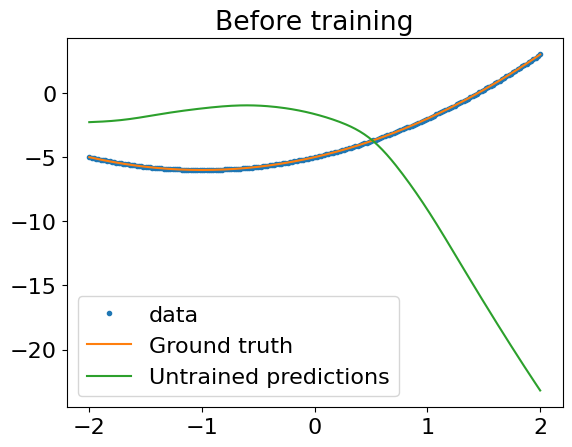

In [5]:
model = Model()
plt.plot(x.numpy(), y.numpy(), '.', label='data')
plt.plot(x, f(x),  label='Ground truth')
plt.plot(x, model(x), label='Untrained predictions')
plt.title('Before training')
plt.legend();

In [6]:
model.train(x,y)

-->training_starting
Iter: 0 Mean squared error: 88.994080
Iter: 100 Mean squared error: 30.198666
Iter: 200 Mean squared error: 11.009109
Iter: 300 Mean squared error: 3.906045
Iter: 400 Mean squared error: 1.429597
Iter: 500 Mean squared error: 0.600462
Iter: 600 Mean squared error: 0.283800
Iter: 700 Mean squared error: 0.145855
Iter: 800 Mean squared error: 0.082141
Iter: 900 Mean squared error: 0.051839
Iter: 1000 Mean squared error: 0.036782
Iter: 1100 Mean squared error: 0.028570
Iter: 1200 Mean squared error: 0.023432
Iter: 1300 Mean squared error: 0.019769
Iter: 1400 Mean squared error: 0.016923
Iter: 1500 Mean squared error: 0.014614
Iter: 1600 Mean squared error: 0.012704
Iter: 1700 Mean squared error: 0.011107
Iter: 1800 Mean squared error: 0.009762
Iter: 1900 Mean squared error: 0.008618


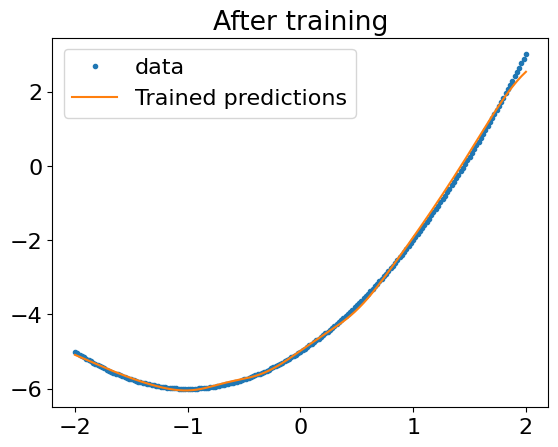

In [7]:
plt.plot(x.numpy(),y.numpy(), '.', label="data")
plt.plot(x, model(x), label='Trained predictions')
plt.title('After training')
plt.legend();

In [8]:
model.net_du(tf.constant([5.0]))

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.354057], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.00215562], dtype=float32)>)

In [9]:
def df(x):
  y = 2*x + 2
  return y

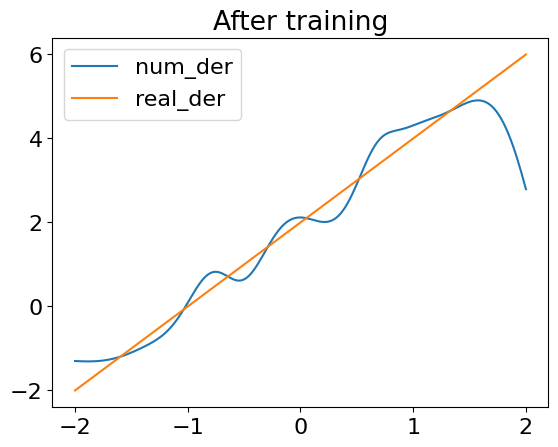

In [10]:
plt.plot(x, model.net_du(x)[0],  label='num_der')
plt.plot(x, df(x), label='real_der')
plt.title('After training')
plt.legend();

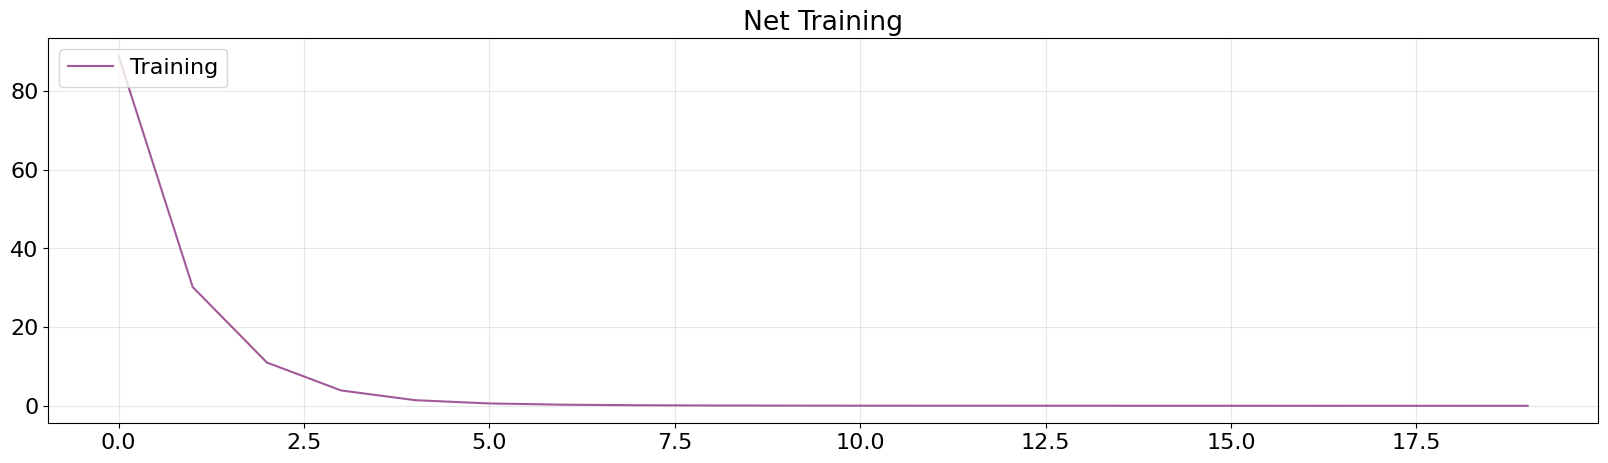

In [11]:
plt.figure(figsize=(20,5))
plt.plot(model.history, label='Training', alpha=.8, color='#8A307F', markersize=20)
plt.legend(loc='upper left')
plt.title('Net Training')
plt.grid(alpha=.3)